In [23]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping


In [11]:
# 2. LOAD THE DATASET

df = pd.read_csv("/content/sms_spam_medium.csv")
df.head()


,label,message
0,ham,Please submit the assignment by tonight.
1,ham,Please submit the assignment by tonight.
2,ham,"Hey, are we still meeting today?"
3,spam,Free recharge available. Visit the link.
4,spam,Free recharge available. Visit the link.


In [24]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df["clean"] = df["message"].apply(clean_text)

df["label_num"] = df["label"].map({"ham": 0, "spam": 1})

In [25]:
X = df["clean"].values
y = df["label_num"].values

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [26]:
VOCAB = 5000
MAXLEN = 60

tokenizer = Tokenizer(num_words=VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

x_train_pad = pad_sequences(x_train_seq, maxlen=MAXLEN)
x_test_pad = pad_sequences(x_test_seq, maxlen=MAXLEN)



In [27]:
model = Sequential([
    Embedding(VOCAB, 128, input_length=MAXLEN),

    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.4),

    Bidirectional(LSTM(64)),
    Dropout(0.3),

    Dense(64, activation="relu"),
    Dropout(0.3),

    Dense(1, activation="sigmoid")
])

model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics=["accuracy"]
)

model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    x_train_pad, y_train,
    epochs=12,
    batch_size=32,
    validation_data=(x_test_pad, y_test),
    callbacks=[es],
    verbose=2
)


Epoch 1/12
5/5 - 10s - 2s/step - accuracy: 0.5125 - loss: 0.6915 - val_accuracy: 0.5000 - val_loss: 0.6879
Epoch 2/12
5/5 - 2s - 319ms/step - accuracy: 0.6000 - loss: 0.6877 - val_accuracy: 1.0000 - val_loss: 0.6784
Epoch 3/12
5/5 - 2s - 499ms/step - accuracy: 0.7188 - loss: 0.6706 - val_accuracy: 0.7250 - val_loss: 0.6578
Epoch 4/12
5/5 - 1s - 291ms/step - accuracy: 0.8250 - loss: 0.6397 - val_accuracy: 0.8000 - val_loss: 0.6078
Epoch 5/12
5/5 - 2s - 328ms/step - accuracy: 0.9187 - loss: 0.5691 - val_accuracy: 0.9250 - val_loss: 0.4897
Epoch 6/12
5/5 - 3s - 574ms/step - accuracy: 0.9187 - loss: 0.4184 - val_accuracy: 1.0000 - val_loss: 0.2737
Epoch 7/12
5/5 - 4s - 755ms/step - accuracy: 0.9875 - loss: 0.1903 - val_accuracy: 1.0000 - val_loss: 0.0636
Epoch 8/12
5/5 - 2s - 326ms/step - accuracy: 1.0000 - loss: 0.0409 - val_accuracy: 1.0000 - val_loss: 0.0133
Epoch 9/12
5/5 - 2s - 318ms/step - accuracy: 1.0000 - loss: 0.0161 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 10/12
5/5 - 2s 

In [30]:
loss, acc = model.evaluate(x_test_pad, y_test, verbose=0)
print(f" FINAL TEST ACCURACY: {acc*100:.2f}%")


 FINAL TEST ACCURACY: 100.00%


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 723ms/step


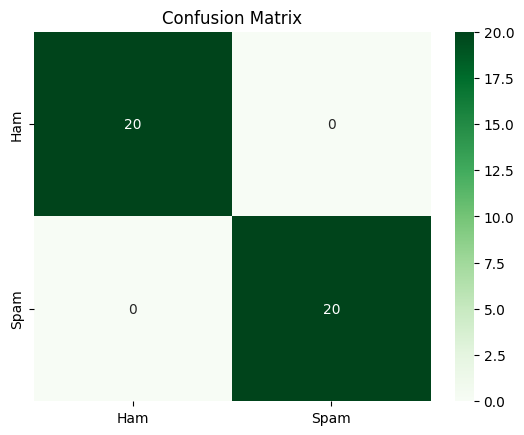

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [31]:
y_pred = (model.predict(x_test_pad) > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred))


In [33]:
def predict_sms(msg):
    cleaned = clean_text(msg)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=MAXLEN)
    pred = model.predict(pad)[0][0]
    return "SPAM" if pred > 0.5 else "HAM ✔"

print(predict_sms("Win a free iPhone now!"))
print(predict_sms("Hey I will reach in 10 minutes"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
SPAM
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
SPAM
